In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
DATA_DIR = "./data" # Local

In [3]:
train_df = pd.read_csv(DATA_DIR + '/train.csv')
print(train_df.shape)
train_df.head()

(1549, 7)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


## Spinning up a dead simple RF Regressor as $f(Age, Weeks) \rightarrow FVC $ with no feature engineering

In [4]:
X, y = train_df[["Age", "Weeks"]], train_df[["FVC"]]
n_samples = len(X)
y = y.values.reshape(n_samples, )
regr = RandomForestRegressor(max_depth=2, random_state=0)
X.head()

,Age,Weeks
0,79,-4
1,79,5
2,79,7
3,79,9
4,79,11


In [5]:
regr.fit(X.values, y)
y_pred = regr.predict(X)
print(f'Training Metrics: \nR2 Score {r2_score(y, y_pred)} \nMAE {mean_absolute_error(y, y_pred)} ')

Training Metrics: 
R2 Score 0.07724846028259702 
MAE 619.0052470157945 


## let's one hot encode and add in $SmokingStatus$ as a feature to see if we can improve it

In [6]:
# need to one hot encode SmokingStatus and then add it back to the DF to train on
cats = train_df[["SmokingStatus"]]
cats = pd.concat([cats, pd.get_dummies(cats['SmokingStatus'], prefix='SS',)],axis=1).drop(['SmokingStatus'],axis=1)
newX = pd.concat([X, cats], axis=1)
newX.head()

,Age,Weeks,SS_Currently smokes,SS_Ex-smoker,SS_Never smoked
0,79,-4,0,1,0
1,79,5,0,1,0
2,79,7,0,1,0
3,79,9,0,1,0
4,79,11,0,1,0


In [7]:
regr.fit(newX.values, y)
newy_pred = regr.predict(newX)
print(f'Training Metrics: \nR2 Score {r2_score(y, newy_pred)} \nMAE {mean_absolute_error(y, newy_pred)} ')

Training Metrics: 
R2 Score 0.14785011256900105 
MAE 600.4973901816012 


In [8]:
train_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [10]:
train_df_copy = train_df.copy()
patients = train_df_copy.Patient.unique().tolist()

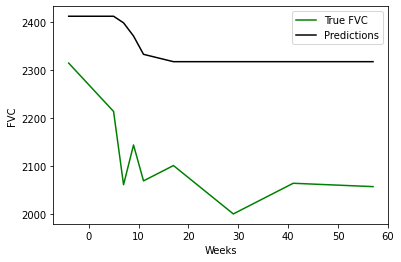

In [11]:
cats = train_df_copy[["SmokingStatus"]]

cats = pd.concat([cats, pd.get_dummies(cats['SmokingStatus'], prefix='SS',)],axis=1).drop(['SmokingStatus'],axis=1)
train_df_copy = pd.concat([train_df_copy, cats], axis=1)

for p in patients[:1]:
    one_patient = train_df_copy[train_df_copy.Patient == p]
    one_patient = one_patient.sort_values(by=['Weeks'])
    predictions = regr.predict(one_patient[["Age", "Weeks", "SS_Currently smokes", "SS_Ex-smoker", "SS_Never smoked"]].values)
    one_patient.plot(kind='line',x='Weeks',y='FVC',color='green', label="True FVC")
    plt.plot(one_patient[["Weeks"]].values, predictions, 'k', label="Predictions")
    plt.ylabel("FVC")
    plt.legend()
plt.show()